# Title

authors: Bolzonello Enrico, Carlesso Daniel, Zadro Michele

## Dataset Setup

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import warnings
from toolbox import connect_poi
import rtree
import os

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

In [2]:
PLACE_NAME = "Padova, Veneto, Italy"

First we need the Padua street network, which we get from OpenStreetMap thanks to the Python library OSMnx

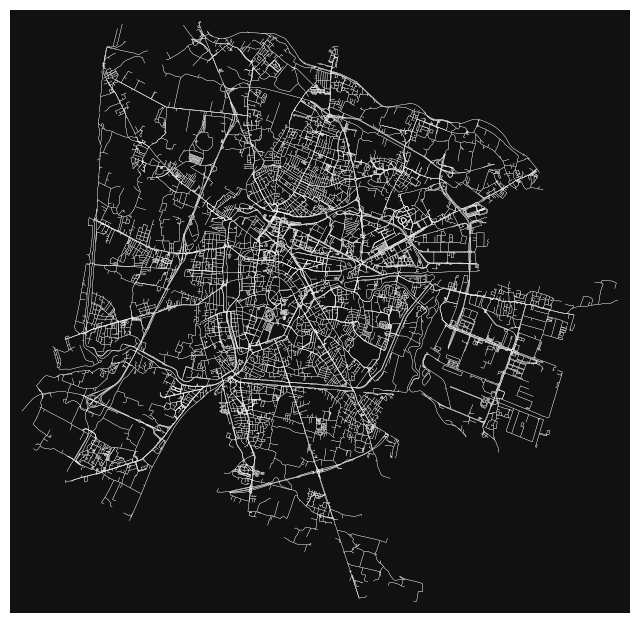

In [3]:
G_padova = ox.graph_from_place(PLACE_NAME, network_type="walk", simplify=True)
fig, ax = ox.plot_graph(G_padova, node_size=0, edge_color="w", node_color="r", edge_linewidth=0.2)

In [4]:
len(G_padova)

20360

The number of nodes for the Padua street network is too large, since complex interchanges and roundabouts form clusters of nodes where the real connection is essentialy only one. So the next step is to simplify the street network, assuming nodes at maximum 15 meters are the same intersection

In [5]:
G_proj = ox.project_graph(G_padova)
G_padova_simplified = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G_padova_simplified)

5462

To make clear what's happening, let's make an example to see it visually.
This is the graph before simplification:

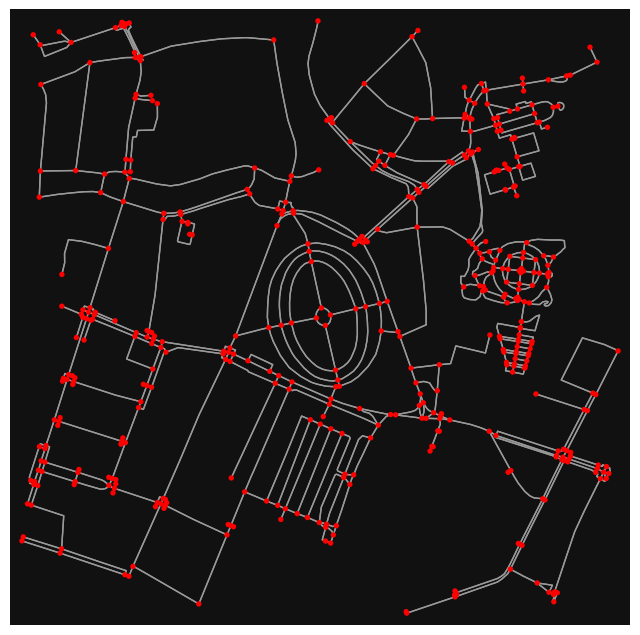

In [6]:
point = 45.39840,11.87644
G_ex = ox.graph_from_point(point, network_type="walk", dist=500)
fig, ax = ox.plot_graph(G_ex, node_color="r")

It is interesting to observe that complex intersections are represented by multiple nodes, which is not what we need.
After consolidating the intersections, the graph becomes:

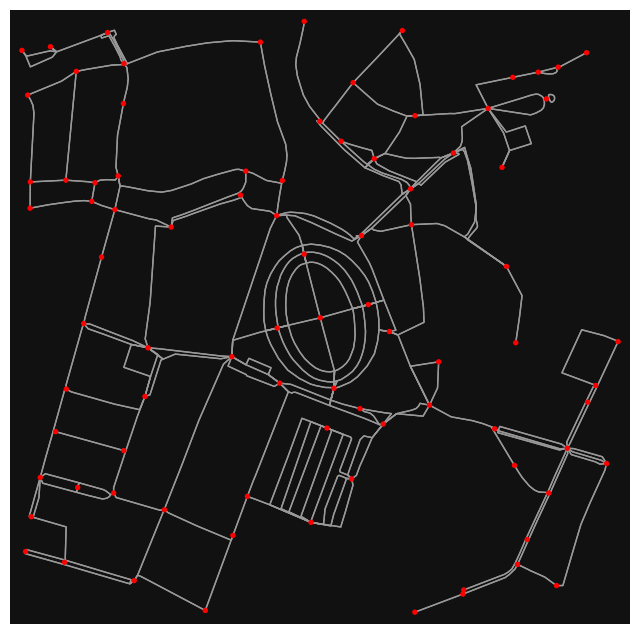

In [7]:
G_proj_ex = ox.project_graph(G_ex)
G_ex_simple = ox.consolidate_intersections(G_proj_ex, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(G_ex_simple, node_color="r")

which conforms much better to modeling.
The drawback is an over-simplification of some connections, like the section at east of Prato della Valle, which is actually the Botanic garden, so simplifying to few nodes is not actually a big deal.
Another example is in the South, where there are a few close parallel connections, but it turns out to be a parking spot, so it is no big deal to over-simplify it.

In [8]:
ox.save_graph_shapefile(G_padova_simplified, filepath='data/example/', encoding='utf-8')

In [9]:
nodes_gdf = gpd.read_file('data/sample/nodes.shp')
edges_gdf = gpd.read_file('data/sample/edges.shp')
#nodes_gdf, edges_gdf = ox.utils_graph.graph_to_gdfs(G_padova_simplified)
nodes_gdf.head()

,osmid,y,x,street_cou,highway,ref,geometry
0,239951901,1.341487,103.853449,3,None,None,POINT (103.85345 1.34149)
1,239952032,1.339230,103.852346,3,traffic_signals,None,POINT (103.85235 1.33923)
2,239952084,1.340837,103.847138,4,traffic_signals,None,POINT (103.84714 1.34084)
3,239952187,1.335395,103.843324,3,None,None,POINT (103.84332 1.33540)
4,239952267,1.331628,103.846350,4,traffic_signals,None,POINT (103.84635 1.33163)


In [10]:
edges_gdf.head(10)

,u,v,key,osmid,oneway,lanes,highway,maxspeed,reversed,length,from,to,name,service,tunnel,bridge,access,width,junction,geometry
0,239951901,439988376,0,74981331,0,2,trunk_link,40,False,61.877,439988376,239951901,None,None,None,None,None,None,None,"LINESTRING (103.85331 1.34095, 103.85337 1.341..."
1,239952032,439988372,0,74703900,0,None,secondary,40,True,17.364,439988372,239952032,Lorong 6 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.85246 1.33912, 103.85235 1.33923)"
2,239952032,3371653877,0,447712971,0,2,secondary,50,False,70.058,3371653877,239952032,Lorong 1 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.85186 1.33964, 103.85199 1.339..."
3,239952032,8026839602,0,447712978,0,2,secondary,50,True,6.358,8026839602,239952032,Lorong 6 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.85238 1.33927, 103.85236 1.339..."
4,239952084,6190806488,0,122672634,0,2,tertiary,50,True,11.059,6190806488,239952084,Lorong 2 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84713 1.34074, 103.84714 1.34084)"
5,239952084,2642043209,0,258894422,0,None,tertiary,50,False,11.081,2642043209,239952084,Lorong 2 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84714 1.34094, 103.84714 1.34084)"
6,239952084,6211531515,0,481680365,0,3,secondary,50,False,18.114,6211531515,239952084,Lorong 1 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84730 1.34083, 103.84714 1.34084)"
7,239952084,2642043202,0,537045070,0,None,secondary,50,True,8.818,2642043202,239952084,Lorong 1 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84706 1.34084, 103.84714 1.34084)"
8,239952187,11323145425,0,"[481676840, 481674941]",0,3,secondary,50,True,36.633,11323145425,239952187,Lorong 1 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84327 1.33507, 103.84327 1.335..."
9,239952187,1370098619,0,827671974,0,3,secondary,50,False,43.574,1370098619,239952187,Lorong 1 Toa Payoh,None,None,None,None,None,None,"LINESTRING (103.84340 1.33578, 103.84334 1.335..."


In [11]:
default_crs = str(G_padova_simplified.graph["crs"])
default_crs

'EPSG:32632'

### Point of Interests (POIs)
Let's define the POIs we are interested in, the full table can be found in the presentation paper.

In [12]:
# just for easy scalability
buildings_names = {
    "education": ["school", "kindergarten", "library"],
    "bank": ["bank", "atm"],
    "healthcare": ["clinic", "doctors", "hospital", "pharmacy"],
    "transportation": ["stop_position"],
    "food": ["supermarket","convenience","greengrocer"]
}

For each group, let's create a GeoDataFrame and save it in another dictionary for easy access.

In [13]:
buildings_gdf = dict.fromkeys(buildings_names.keys())
for type in buildings_gdf.keys():
    # set the key (based on OSM specification)
    poi_key = "amenity"
    if type == "transportation":
        poi_key = "public_transport"
    if type == "food":
        poi_key = "shop"

    # set the value (simply the array)
    poi_value = buildings_names[type]

    # create the GeoDataFrame
    buildings_gdf[type] = ox.features_from_place(
            PLACE_NAME,
            {poi_key: poi_value}
        )

    # convert to the same crs as the graph
    buildings_gdf[type].to_crs(crs=default_crs, inplace=True)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/releas

In [14]:
# just for checking that the crs is set accordingly
for t in buildings_gdf.keys():
    print(buildings_gdf[t].crs)

EPSG:32632
EPSG:32632
EPSG:32632
EPSG:32632
EPSG:32632


In [15]:
buildings_gdf['food']
for id, geom in buildings_gdf['food'].iteritems():
    print(id, geom)
    break

addr:housenumber element_type  osmid     
node          256072065      31
              296955042     NaN
              296955316     NaN
              296963264     NaN
              334511575      61
                           ... 
way           723610182      25
              775415671     NaN
              777319580     NaN
              827115934     NaN
              1204651301     72
Name: addr:housenumber, Length: 129, dtype: object


In [16]:
#Polygon to Point conversion
for category in buildings_names.keys():
    buildings_gdf[category]['geometry'] = buildings_gdf[category]['geometry'].apply(lambda p: p.centroid if p.geom_type == 'Polygon' else p)
    buildings_gdf['lon'] = buildings_gdf[category]['geometry'].apply(lambda p: p.x)
    buildings_gdf['lat'] = buildings_gdf[category]['geometry'].apply(lambda p: p.y)

print(buildings_gdf['food']['geometry'].to_string(index=False))

element_type  osmid      
POINT (723632.474 5032541.232)
POINT (724512.660 5035388.753)
POINT (724582.277 5036785.715)
POINT (725772.090 5035923.059)
POINT (727563.488 5032836.529)
POINT (727938.915 5031850.460)
POINT (725302.197 5033381.193)
POINT (730218.405 5031429.185)
POINT (726506.302 5031459.438)
POINT (725460.828 5034975.669)
POINT (723635.391 5032098.847)
POINT (726841.414 5029783.225)
POINT (725032.713 5032336.551)
POINT (725302.899 5032120.324)
POINT (725183.099 5032246.470)
POINT (724055.872 5030862.390)
POINT (726361.152 5029003.423)
POINT (727280.474 5029204.894)
POINT (725669.016 5031681.193)
POINT (727145.685 5029378.478)
POINT (725347.862 5030480.973)
POINT (724976.109 5032282.735)
POINT (726279.366 5035536.244)
POINT (726823.383 5034792.171)
POINT (726014.812 5034780.532)
POINT (725402.873 5033731.035)
POINT (725896.573 5034522.294)
POINT (724894.892 5033073.018)
POINT (725072.735 5032738.598)
POINT (724499.727 5032159.509)
POINT (727767.064 5031083.675)
POINT (727020

In [17]:
new_nodes, new_edges = connect_poi(buildings_gdf['food'], nodes_gdf, edges_gdf, key_col='key', path=None)

Building rtree...
Updating external nodes...


KeyError: "['key'] not in index"

In [ ]:
meter_epsg=3857
edges_meter = edges_gdf.to_crs(epsg=meter_epsg)

In [ ]:
for fid, geom in edges_meter['geometry'].iteritems():
    print("".join(int(fid)), geom.bounds)
#Rtree = rtree.index.Index()
#[Rtree.insert(fid, geom.bounds) for fid, geom in edges_meter['geometry'].iteritems()]